In [1]:
import matplotlib
import numpy as np
from qiskit import QuantumCircuit
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

## The Deutsch-Jozsa Algorithm

In the Deutsch-Jozsa problem, we are provided with an oracle that implements a function $f: \{0,1\}^n \rightarrow \{0, 1\}$. It is guaranteed that the function $f$ is either **balanced or constant**. The problem is to determine if the given oracle implements a balanced function or a constant function.

The classical solution to the Deutsch-Jozsa problem requires $2^{n-1} + 1$ queries to the oracle, in the worst case.

The quantum solution requires just **one**.


### The quantum solution

We start with the $n + 1$ qubit quantum register set to the state $|0\rangle^{\otimes n}|1\rangle$. A Hadamard transform is applied to all qubits. This results in the state
$$
\begin{equation}
    H^{\otimes n}|0\rangle^{\otimes n}|1\rangle = \frac{1}{\sqrt{2^{n+1}}}\sum_{x = 0}^{2^n - 1}|x\rangle(|0\rangle - |1\rangle)
\end{equation}
$$

Next we apply the oracle $U_f$. The oracle maps the state $|x\rangle|y\rangle$ to $|x\rangle|y \oplus f(x)\rangle$. Therefore, we obtain, 
$$
\begin{equation}
    \frac{1}{\sqrt{2^{n+1}}}\sum_{x = 0}^{2^n - 1}|x\rangle(|f(x)\rangle - |1 \oplus f(x)\rangle)
\end{equation}
$$
which can be simplified by accounting for the fact that for each $x$, $f(x) = 0, 1$
$$
\begin{equation}
    \frac{1}{\sqrt{2^{n+1}}}\sum_{x = 0}^{2^n - 1}(-1)^{f(x)}|x\rangle(|0\rangle - |1\rangle)
\end{equation}
$$

The last qubit can be discarded and only the first n qubits can be considered for further operations. Apply the Hadamard transform again on the first n qubits. We then obtain the state
$$
\begin{equation}
    \frac{1}{\sqrt{2^{n}}}\sum_{x = 0}^{2^n - 1}(-1)^{f(x)}\left[\frac{1}{\sqrt{2^{n}}}\sum_{y = 0}^{2^n - 1}(-1)^{x\cdot y}|y\rangle\right] = \frac{1}{2^{n}}\sum_{x = 0}^{2^n - 1}\sum_{y = 0}^{2^n - 1}(-1)^{f(x) + x\cdot y}|y\rangle
\end{equation}
$$

Now, the probabilty of measuring the state $|0\rangle^{\otimes n}$ is
$$
\begin{equation}
  \left|\frac{1}{2^{n}}\sum_{x = 0}^{2^n - 1}(-1)^{f(x)}\right|^2
\end{equation}
$$

This evaluates to 1 if $f(x)$ is constant, and 0 if $f(x)$ is constant. The implication of this statement is that measurement will yield $|0\rangle^{\otimes n}$ *only* if $f(x)$ is constant, and other states if $f(x)$ is balanced. 

In [2]:
class DeutchJozsaCirc:
    def __init__(self, n, ftype):
        self.n = n
        self.ftype = ftype
    
    def DJoracle(self):
        circ = QuantumCircuit(self.n + 1)

        if self.ftype == "constant":
            out = np.random.randint(2)
            if out == 1:
                circ.x(self.n)

        elif self.ftype == "balanced":
            for qubit in range(n):
                circ.cx(qubit, n)

        
        oracle = circ.to_gate()
        oracle.name = "oracle"
        return oracle
    
    def assembleCirc(self):
        circ = QuantumCircuit(self.n+1, self.n)
        circ.x(n)
        circ.h(range(self.n + 1))
        circ.barrier()
        
        circ.append(self.DJoracle(), range(self.n + 1))
        circ.barrier()
        
        circ.h(range(self.n ))
        
        for i in range(self.n):
            circ.measure(i, i)
        
        return circ

### $f(x)$ is Balanced 

In [3]:
n = 4
ftype = "balanced"
dj_circ_bal = DeutchJozsaCirc(n, ftype).assembleCirc()

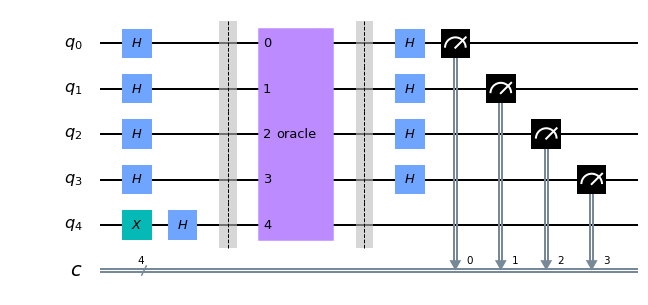

In [4]:
dj_circ_bal.draw('mpl')

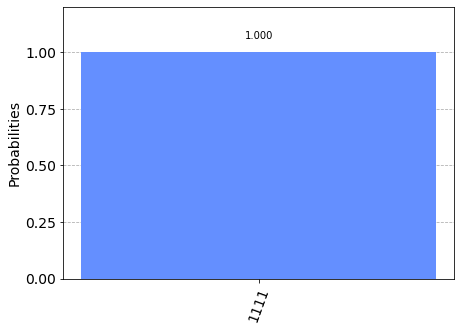

In [5]:
backend = Aer.get_backend('qasm_simulator')
shots = 1024
counts = execute(dj_circ_bal, backend=backend, shots=shots).result().get_counts(dj_circ_bal)
plot_histogram(counts)

### $f(x)$ is Constant

In [6]:
n = 4
ftype = "constant"
dj_circ_const = DeutchJozsaCirc(n, ftype).assembleCirc()

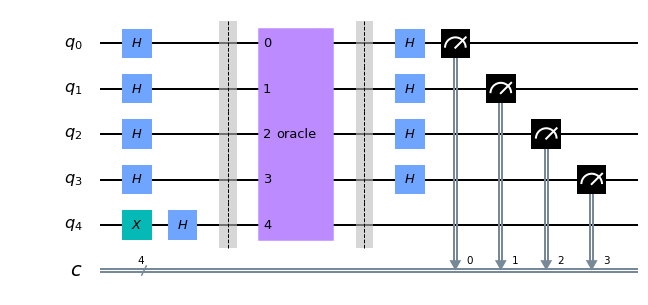

In [7]:
dj_circ_const.draw('mpl')

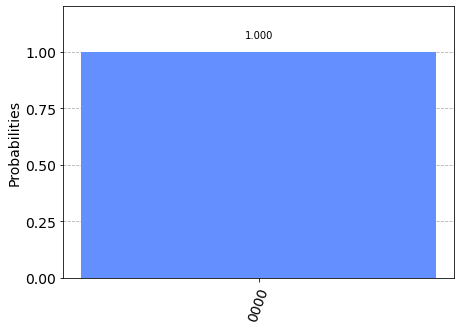

In [8]:
backend = Aer.get_backend('qasm_simulator')
shots = 1024
counts = execute(dj_circ_const, backend=backend, shots=shots).result().get_counts(dj_circ_const)
plot_histogram(counts)